# Case-study 3: Simulating network equilibrium under road pricing

In [ ]:
# Package Import
from IPython import display
import time
import pylab as pl
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import pandas as pd
import math 
import itertools
import seaborn as sns
#from math import floor        

In [ ]:
# flow rate
rate = [1000, 2500, 1500] #(veh/hour for the three periods of 4-7 am, 7-9 am, 9-13)

# total simulation  time
period = [3,2,4] #(hours) #3

#week = array([[3,2,4],]*7) # 3 days

# and we descritize time as
stepsize = 60 #(minutes) #30

# coefficient for travel time in the route choice model (mean, sigma)
theta_rc = [-0.15, 0.1]

# travel time on the two roads: 1, 2
tt0 = [20,30] #(min)
# edge capacity

cap = [2100, 1200] #(veh)
cap[:] = [x / (60/stepsize) for x in cap]

# BPR's beta
beta = 2


In [ ]:
cap

[2100.0, 1200.0]

## Agents

Let's create a new class (`agent2`) for the agents. 
We generate all initial fields of interest, namely the `id`, `theta_n` (drawn from the normal distribution defined) and `t0` genreated with a Poisson Process; we also include choice related variables and experienced trip attributes as memory of the agent, namely: `p1` and `p2` as the probability of chosing each of the paths, `path` as the selected path and, `tt` and `tf`as trip total and end times. These memory variables are initialized empty / with zero.

In [ ]:
drivers = pd.DataFrame()
drivers = pd.DataFrame(columns = ['id', 'theta', 'p1', 'p2', 'path', 'tt', 't0','tf','toll','v1','v2'] )

# let's assign id, theta and starting times

timestamp = 0
id = 0
toll = 0
for i in range(0,len(rate)):
    ref_period = floor(timestamp)
    while timestamp <  ref_period + period[i]:
        arrival_headway = np.random.exponential(1.0/rate[i]) 
        timestamp += arrival_headway

        # Define toll period
        if timestamp >= ref_period + period[i]:
            break
        if timestamp > 3 and timestamp < 5: # toll in the period 7-9 am with starting travelling time =4 am
            toll = 5
        else:
            toll = 0
        
        
        id += 1
        theta_driver = np.random.normal(theta_rc[0],theta_rc[1],1)
        new_row = {'id': id, 'theta': theta_driver[0] ,'p1': None, 'p2':None , 'path':None , 'tt': None , 't0': timestamp,'tf':None, 'toll': toll,'v1':None,'v2':None} 
        drivers = drivers.append(new_row, ignore_index=True)    
        

In [ ]:
drivers

,id,theta,p1,p2,path,tt,t0,tf,toll,v1,v2
0,1.0,-0.150710,NaN,NaN,NaN,NaN,0.000675,NaN,0.0,NaN,NaN
1,2.0,-0.128792,NaN,NaN,NaN,NaN,0.003241,NaN,0.0,NaN,NaN
2,3.0,-0.154784,NaN,NaN,NaN,NaN,0.003294,NaN,0.0,NaN,NaN
3,4.0,-0.126537,NaN,NaN,NaN,NaN,0.004641,NaN,0.0,NaN,NaN
4,5.0,-0.063478,NaN,NaN,NaN,NaN,0.004925,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
14322,14323.0,-0.175979,NaN,NaN,NaN,NaN,8.994715,NaN,0.0,NaN,NaN
14323,14324.0,-0.032987,NaN,NaN,NaN,NaN,8.994845,NaN,0.0,NaN,NaN
14324,14325.0,-0.279506,NaN,NaN,NaN,NaN,8.995136,NaN,0.0,NaN,NaN
14325,14326.0,-0.084525,NaN,NaN,NaN,NaN,8.997594,NaN,0.0,NaN,NaN


In [ ]:
drivers['t0'].max()

8.999160728997477

In [ ]:
drivers['t0'].min()

0.0006753920581717894

## Generation of the network 

Similarly let's generate a `data.frame` for hosting the network details. 
*Note*: For visualization we will algo use the package `igraph` which could also be used in the modelling of the network. For simplicity of this ilustration we keep the `data.frame` architecture.

We also use two memory variables: `flow` and `tt`.

In [ ]:
g_2r = pd.DataFrame()
g_2r = pd.DataFrame(columns = ['id', 'flow','tt'])

g_2r['id']=[1,2]
g_2r['flow']=[0,0]
g_2r['tt']=tt0

In [ ]:
g_2r

,id,flow,tt
0,1,0,20
1,2,0,30


## Generation of a set of generic functions

- path_choice
- move

The agent's choice, `path_choice`. Here we:
- compute systematic utility for each path
- compute the probability of each path
- make a random draw from uniform distribution to then
- draw from the discrete distribution of probabilities

In [ ]:
def path_choice(drivers, g_2r):
    
    # compute systematic utility
    
    #Calculate utility functions with tolls
    v1 = drivers['theta'] * (g_2r['tt'][0]) - drivers['toll'] #adjust the systematic utility function for path 1 by deducting the toll value
    v2 = drivers['theta'] * (g_2r['tt'][1])
    
    # compute probabilities
    drivers['p1'] = np.exp(v1)/(np.exp(v1)+np.exp(v2))
    drivers['p2'] = 1 - drivers['p1']

    drivers['v1']=v1
    drivers['v2']=v2
    
    # generate random choice
    randdraw = np.random.uniform(low=0.0, high=1.0, size=len(drivers))
    drivers['path'] = 2 - (randdraw <= drivers['p1']) # if true =1 if not =2
    return drivers

Let’s now create the move function for the agent’s movement on the network assigning the arrival time to drivers.

In [ ]:
def move(drivers, g_2r):
    drivers['tt'] = (2-drivers['path']) * (g_2r['tt'][0]) + (drivers['path'] -1) * (g_2r['tt'][1])
    drivers['tf'] = drivers['t0'] + drivers['tt']/60
    return drivers

Finally let's update the link attributes

In [ ]:
def update_network(network, drivers_in, drivers_out, cap):
    #flow in paths 
    path1_in_out = [sum(drivers_in['path']==1), sum(drivers_out['path']==1)]
    path2_in_out = [sum(drivers_in['path']==2), sum(drivers_out['path']==2)]
    #update flow in edges
    network['flow'] = network['flow'] + [path1_in_out[0],path2_in_out[0]] - [path1_in_out[1],path2_in_out[1]]
    # tt update
    network['tt'] = tt0 + tt0 * np.power((network['flow']/cap),beta)
    return network

Perform the simulation

In [ ]:
DF_list = list()
DF_list.append(g_2r)

for iterate in range(1,int(sum(period)*(60/stepsize))+1):
#for iterate in range(1,2): #just to simulate 1 iteration
    entering = np.where(floor(drivers['t0']*(60/stepsize)) == iterate-1)
    exiting = np.where(floor(drivers['tf']*(60/stepsize)) == iterate-2)
    # make the choice
    drivers.update(path_choice(drivers.loc[entering],DF_list[iterate-1]))
    # move
    drivers.update(move(drivers.loc[entering],DF_list[iterate-1]))
    # save state and update the network
    new_state = DF_list[iterate-1].copy()
    new_state = update_network(new_state,drivers.loc[entering], drivers.loc[exiting],cap)
    DF_list.append(new_state)
drivers.update(move(drivers.loc[entering],DF_list[iterate]))

In [ ]:
DF_list

[   id  flow  tt
 0   1     0  20
 1   2     0  30,    id  flow         tt
 0   1   809  22.968168
 1   2   209  30.910021,    id  flow         tt
 0   1  1024  24.755447
 1   2   361  32.715021,    id  flow         tt
 0   1  1020  24.718367
 1   2   403  33.383521,    id  flow          tt
 0   1   384   20.668735
 1   2  2667  178.185188,    id  flow         tt
 0   1  2343  44.896367
 1   2  1712  91.061333,    id  flow         tt
 0   1  2214  42.230367
 1   2   443  34.088521,    id  flow         tt
 0   1  1472  29.826685
 1   2  1546  79.794083,    id  flow         tt
 0   1  1675  32.723923
 1   2  1128  56.508000,    id  flow         tt
 0   1  2085  39.715306
 1   2   260  31.408333]

In [ ]:
drivers

,id,theta,p1,p2,path,tt,t0,tf,toll,v1,v2
0,1.0,-0.150710,0.818630,0.181370,1.0,20.000000,0.000675,0.334009,0.0,-3.014193,-4.521289
1,2.0,-0.128792,0.783796,0.216204,1.0,20.000000,0.003241,0.336575,0.0,-2.575849,-3.863773
2,3.0,-0.154784,0.824601,0.175399,1.0,20.000000,0.003294,0.336628,0.0,-3.095675,-4.643513
3,4.0,-0.126537,0.779949,0.220051,1.0,20.000000,0.004641,0.337974,0.0,-2.530743,-3.796115
4,5.0,-0.063478,0.653572,0.346428,1.0,20.000000,0.004925,0.338258,0.0,-1.269552,-1.904329
...,...,...,...,...,...,...,...,...,...,...,...
14322,14323.0,-0.175979,0.985013,0.014987,1.0,39.715306,8.994715,9.656637,0.0,-5.758719,-9.944214
14323,14324.0,-0.032987,0.686662,0.313338,1.0,39.715306,8.994845,9.656767,0.0,-1.079454,-1.864012
14324,14325.0,-0.279506,0.998705,0.001295,1.0,39.715306,8.995136,9.657058,0.0,-9.146526,-15.794314
14325,14326.0,-0.084525,0.881879,0.118121,1.0,39.715306,8.997594,9.659516,0.0,-2.765984,-4.776330


In [ ]:
#total travel time
def total_tt(my_drivers):
    return sum(my_drivers['tt'])

In [ ]:
# total (simulated) welfare
def welfare(my_drivers):
    # we are now ignoring the error term of the utility
    return sum(my_drivers['theta'] * my_drivers['tt'])

In [ ]:
welfare(drivers)

-64933.952495659876

In [ ]:
# Price of Anarchy - Welfare 

# In order to derive the welfare without the tolls we run the code without the part where the toll period is defined using the initial utility functions

welfare_without_toll = -70319.06421930509

# Next we run the code with the part where the toll period is defined using the utility function with the toll substraction
welfare_with_toll =welfare(drivers)

# Now we can calculate the Price of Anarchy for welfare (maximization)
PoA_welfare=welfare_with_toll/welfare_without_toll
print('Price of Anarchy based on welfare:',PoA_welfare)

Price of Anarchy based on welfare: 0.9234188938173212


The total welfare of the drivers without including a toll for the path 1 is lower than after including the toll. This can be expalined by the fact that drivers are selfish they choose the path which is faster which leads into congestion. Once we introduce the toll to the path 1 we balance the flow between the two paths which results is a higher total welfare of drivers.

In [ ]:
total_tt(drivers)

502778.60063747165

In [ ]:
# Price of Anarchy - Travel Times

# In order to derive the travel times without the tolls we run the code without the part where the toll period is defined using the initial utility functions

tt_without_toll = 489179.0518144842

# Next we run the code with the part where the toll period is defined using the utility function with the toll substraction
tt_with_toll = total_tt(drivers)

# Now we can calculate the Price of Anarchy for travel times (minimization) 
PoA_tt=tt_without_toll/tt_with_toll 
print('Price of Anarchy based on travel time:',PoA_tt)

Price of Anarchy based on travel time: 0.9729512178805052


### ***Comment:***

The total welfare of the drivers without including a toll for the path 1 is lower than after including the toll. This can be expalined by the fact that drivers are selfish they choose the path which is faster which leads into congestion. Once we introduce the toll to the path 1 we balance the flow between the two paths which results is a higher total welfare of drivers.


When comparing the total travalling time between the cases of no toll and with toll, we notice that intruducing the toll resulted in a decrease of the total travelling time. The toll for path 1 results in a more efficient flow between path 1 and 2. Hence the drivers spend a toll duration shorter in total.









### MSA

First lets add our MSA step when updating the travel times in `update_network` function:

In [ ]:
def update_network_msa(network, drivers_in, drivers_out, cap,k):

    #flow in paths 
    path1_in_out = [sum(drivers_in['path']==1), sum(drivers_out['path']==1)]
    path2_in_out = [sum(drivers_in['path']==2), sum(drivers_out['path']==2)]
    #update flow in edges
    aux = network['flow'] + [path1_in_out[0],path2_in_out[0]] - [path1_in_out[1],path2_in_out[1]]
    if (k>1):
        new_flow = ((k-1)/k) *  aux + (1/k) * network['flow']
    else:
        new_flow = aux
    print(new_flow)    
    network['flow'] = aux  
    # tt update
    network['tt'] = tt0 + tt0 * np.power((new_flow/cap),beta)

    return network

Now we will stack each `k` step of the MSA into a list. We will redo all steps above `k` times. Let's start with a new drivers set.

In [ ]:
drivers_msa = pd.DataFrame()
drivers_msa = pd.DataFrame(columns = ['id', 'theta', 'p1', 'p2', 'path', 'tt', 't0','tf','toll','v1','v2'] )

# let's assign id, theta and starting times

timestamp = 0
id = 0
toll=0
for i in range(0,len(rate)):
    ref_period = floor(timestamp)
    while timestamp <  ref_period + period[i]:
        arrival_headway = np.random.exponential(1.0/rate[i]) 
        timestamp += arrival_headway
        if timestamp >= ref_period + period[i]:
            break
        if timestamp > 3 and timestamp < 5:
          toll = 5
        else:
          toll = 0
        id += 1
        theta_driver = np.random.normal(theta_rc[0],theta_rc[1],1)
        new_row = {'id': id, 'theta': theta_driver[0] ,'p1': None, 'p2':None , 'path':None , 'tt': None , 't0': timestamp,'tf':None,'toll': toll,'v1':None,'v2':None } 
        drivers_msa = drivers_msa.append(new_row, ignore_index=True)   

In [ ]:
drivers_msa

,id,theta,p1,p2,path,tt,t0,tf,toll,v1,v2
0,1.0,-0.274841,NaN,NaN,NaN,NaN,0.000781,NaN,0.0,NaN,NaN
1,2.0,-0.028358,NaN,NaN,NaN,NaN,0.002309,NaN,0.0,NaN,NaN
2,3.0,-0.032219,NaN,NaN,NaN,NaN,0.002531,NaN,0.0,NaN,NaN
3,4.0,-0.119405,NaN,NaN,NaN,NaN,0.002921,NaN,0.0,NaN,NaN
4,5.0,-0.344303,NaN,NaN,NaN,NaN,0.005917,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
13952,13953.0,0.203981,NaN,NaN,NaN,NaN,8.995508,NaN,0.0,NaN,NaN
13953,13954.0,-0.055872,NaN,NaN,NaN,NaN,8.997861,NaN,0.0,NaN,NaN
13954,13955.0,-0.154284,NaN,NaN,NaN,NaN,8.999137,NaN,0.0,NaN,NaN
13955,13956.0,-0.200224,NaN,NaN,NaN,NaN,8.999258,NaN,0.0,NaN,NaN


In [ ]:
g_2r_msa = pd.DataFrame()
g_2r_msa = pd.DataFrame(columns = ['id', 'flow','tt'])

g_2r_msa['id']=[1,2]
g_2r_msa['flow']=[0,0]
g_2r_msa['tt']=tt0

# the new thing: let's stack each of the runs in this list:
msa = list()

In [ ]:
# the tt variable is used as stopping criteria for the MSA equilibrium process
diff_tt = float("inf")
k = 1

# Create memory dataframe to store values in order to calculate important variable values in each step(day)
memory_df= pd.DataFrame()
memory_df = pd.DataFrame(columns = ['id', 'flow','tt'])
dynamics = pd.DataFrame(columns = ['v1','v2','Total Travel Time','Total Flow'])

# Stopping criteria check

while diff_tt>0.1:
    DF_list_msa = list()
    if k == 1:
        DF_list_msa.append(g_2r_msa)
    else:
        DF_list_msa.append(msa[len(msa)-1][len(DF_list_msa)-1])
        DF_list_msa[len(DF_list_msa)-1]['flow'] = [0,0]
    
    for iterate in range(1,int(sum(period)*(60/stepsize))+1):
    #if True:
        entering = np.where(floor(drivers_msa['t0']*(60/stepsize)) == iterate-1)
        exiting = np.where(floor(drivers_msa['tf']*(60/stepsize)) == iterate-2) 
        # make the choice
        drivers_msa.update(path_choice(drivers_msa.loc[entering],DF_list_msa[len(DF_list_msa)-1]))
        # move
        drivers_msa.update(move(drivers_msa.loc[entering],DF_list_msa[len(DF_list_msa)-1]))
        # save state and update the network
        new_state = DF_list_msa[iterate-1].copy()
        new_state = update_network_msa(new_state,drivers_msa.loc[entering], drivers_msa.loc[exiting],cap, k)  
        DF_list_msa.append(new_state)                                                                                       
        memory_df=memory_df.append(new_state)

    msa.append(DF_list_msa)

  
    # compute the diffs
    if k >= 2:
        diff_flow = np.sqrt(sum((msa[len(msa)-1][len(DF_list_msa)-1]['flow'] - msa[len(msa)-2][len(DF_list_msa)-1]['flow'])**2))
        diff_tt = np.sqrt(sum((msa[len(msa)-1][len(DF_list_msa)-1]['tt'] - msa[len(msa)-2][len(DF_list_msa)-1]['tt'])**2))

     
    # updare counter
    k += 1
    print(diff_tt)

    dynamics_per_day = {'v1': sum(drivers['v1']), 'v2': sum(drivers['v2']) ,'Total Travel Time': sum(memory_df['tt']),'Total Flow':sum(memory_df['flow'])} # inconsistency is v1-v1(-1) and v2-v2(-1). we need to store the values of v1 and v2 and see the standard deviation between them. Here we look at 10 iteration is enough.
  
    dynamics= dynamics.append(dynamics_per_day,ignore_index=True)

    # Restart memory
    memory_df= pd.DataFrame()
    memory_df = pd.DataFrame(columns = ['id', 'flow','tt'])


0    728
1    238
Name: flow, dtype: int64
0    1009
1     369
Name: flow, dtype: int64
0    1031
1     360
Name: flow, dtype: int64
0     370
1    2562
Name: flow, dtype: int64
0    2231
1    1638
Name: flow, dtype: int64
0    2102
1     443
Name: flow, dtype: int64
0    1338
1    1510
Name: flow, dtype: int64
0    1679
1    1013
Name: flow, dtype: int64
0    1902
1     355
Name: flow, dtype: int64
inf
0    174.0
1    309.0
Name: flow, dtype: float64
0    695.5
1    573.0
Name: flow, dtype: float64
0    1079.0
1     387.0
Name: flow, dtype: float64
0     742.0
1    1388.0
Name: flow, dtype: float64
0    1032.0
1    2358.5
Name: flow, dtype: float64
0    1842.5
1    1571.5
Name: flow, dtype: float64
0    1960.5
1     664.0
Name: flow, dtype: float64
0    1795.0
1     628.5
Name: flow, dtype: float64
0    1562.0
1     965.5
Name: flow, dtype: float64
17.62399917460417
0    554.0
1     90.0
Name: flow, dtype: float64
0    1099.000000
1     263.666667
Name: flow, dtype: float64
0    1071.

In [ ]:
dynamics

,v1,v2,Total Travel Time,Total Flow
0,-88148.934357,-157844.582805,817.338499,20878.0
1,-88148.934357,-157844.582805,779.699869,20983.0
2,-88148.934357,-157844.582805,764.717540,21104.0
3,-88148.934357,-157844.582805,767.396603,21195.0
4,-88148.934357,-157844.582805,773.722312,21185.0
5,-88148.934357,-157844.582805,781.161435,21166.0
6,-88148.934357,-157844.582805,786.020665,21069.0
7,-88148.934357,-157844.582805,791.536435,21088.0


In [ ]:
std(dynamics['Total Travel Time'][-10:])

15.566248341306144

In [ ]:
std(dynamics['Total Flow'][-10:])

101.56401921940663

To test the convergence of the MSA algorithm we look at the standard deviation first for the total travel time (15.57) and then for the total flow (101.56) for the last 10 days.
We notice a small standard deviation in the above 2 variables which reflects that the system converged.


In [ ]:
DF_list_msa

[   id  flow         tt
 0   1     0  36.236756
 1   2     0  34.574150,    id  flow         tt
 0   1   420  20.612500
 1   2   546  34.755105,    id  flow         tt
 0   1  1113  24.777531
 1   2   490  35.146021,    id  flow         tt
 0   1  1065  25.202000
 1   2   295  32.125008,    id  flow          tt
 0   1   372   20.953909
 1   2  2580  139.669930,    id  flow         tt
 0   1  2164  37.068481
 1   2  1690  97.593783,    id  flow         tt
 0   1  2115  40.404405
 1   2   477  38.232696,    id  flow         tt
 0   1  1426  30.369714
 1   2  1352  62.169102,    id  flow         tt
 0   1  1806  34.024137
 1   2   857  47.590235,    id  flow         tt
 0   1  1910  36.320222
 1   2   410  34.521657]

In [ ]:
msa

[[   id  flow  tt
  0   1     0  20
  1   2     0  30,    id  flow         tt
  0   1   728  22.403556
  1   2   238  31.180083,    id  flow         tt
  0   1  1009  24.617147
  1   2   369  32.836687,    id  flow         tt
  0   1  1031  24.820685
  1   2   360  32.700000,    id  flow          tt
  0   1   370   20.620862
  1   2  2562  166.746750,    id  flow         tt
  0   1  2231  42.573066
  1   2  1638  85.896750,    id  flow         tt
  0   1  2102  40.038113
  1   2   443  34.088521,    id  flow         tt
  0   1  1338  28.119020
  1   2  1510  77.502083,    id  flow         tt
  0   1  1679  32.784766
  1   2  1013  51.378521,    id  flow         tt
  0   1     0  36.406367
  1   2     0  32.625521], [   id  flow         tt
  0   1     0  36.406367
  1   2     0  32.625521,    id  flow         tt
  0   1   348  20.137306
  1   2   618  31.989187,    id  flow         tt
  0   1  1043  22.193743
  1   2   528  36.840187,    id  flow         tt
  0   1  1115  25.280005
  1 

In [ ]:
print('Number of iterations',k)

Number of iterations 9


In [ ]:
msa[-1]

[   id  flow         tt
 0   1     0  36.236756
 1   2     0  34.574150,    id  flow         tt
 0   1   420  20.612500
 1   2   546  34.755105,    id  flow         tt
 0   1  1113  24.777531
 1   2   490  35.146021,    id  flow         tt
 0   1  1065  25.202000
 1   2   295  32.125008,    id  flow          tt
 0   1   372   20.953909
 1   2  2580  139.669930,    id  flow         tt
 0   1  2164  37.068481
 1   2  1690  97.593783,    id  flow         tt
 0   1  2115  40.404405
 1   2   477  38.232696,    id  flow         tt
 0   1  1426  30.369714
 1   2  1352  62.169102,    id  flow         tt
 0   1  1806  34.024137
 1   2   857  47.590235,    id  flow         tt
 0   1  1910  36.320222
 1   2   410  34.521657]

In [ ]:
welfare(drivers_msa)

-62715.531704346344

In [ ]:
total_tt(drivers_msa)

485225.9223701554

In [ ]:
# Price of Anarchy - Welfare 

# In order to derive the welfare without the tolls we run the code without the part where the toll period is defined using the initial utility functions
k_without_toll=115
welfare_without_toll = -73695.46932239603 

# Next we run the code with the part where the toll period is defined using the utility function with the toll substraction
k=16
welfare_with_toll =welfare(drivers_msa)

# Now we can calculate the Price of Anarchy for welfare (maximization)
PoA_welfare=welfare_with_toll/welfare_without_toll
print('Price of Anarchy based on welfare:',PoA_welfare)

Price of Anarchy based on welfare: 0.8510093263669211


In [ ]:
# Price of Anarchy - Travel Times

# In order to derive the travel times without the tolls we run the code without the part where the toll period is defined using the initial utility functions

tt_without_toll = 507153.7250365775

# Next we run the code with the part where the toll period is defined using the utility function with the toll substraction
tt_with_toll = total_tt(drivers_msa)

# Now we can calculate the Price of Anarchy for travel times (minimization) 
PoA_tt=tt_without_toll/tt_with_toll
print('Price of Anarchy based on travel time:',PoA_tt)

Price of Anarchy based on travel time: 1.04519091346009


Before implementing the toll, the number of repetitions in the MSA to reach the equilibrium is equal to 115, while after the introduction of the toll, only 9 iterations are needed.
The equilibrium is reached more than 12 times faster since the flow between paths 1 and 2 is divided more efficiently.

The total welfare of the drivers increased while the total driving time decreased by 3% and 3% respectively.

The price of Anarchy based welfare and travel time are equal to 0.85101 and 1.04519 respectively.



Create a new function to update travelers perception at every step based on the folowing formula: 

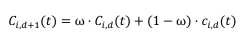

In [ ]:
def path_choice_days(drivers, g_2r,day,old_drivers,old_state,learning_rate): # old_state is the state in the previous day, and old_drivers are the drivers of the previous day

  # compute systematic utility

  #intial iteration ( first day)
  if day == 1:
    v1 = drivers['theta'] * (g_2r['tt'][0]) - drivers['toll']
    v2 = drivers['theta'] * (g_2r['tt'][1])
              
  else:
          
    # Create the new utility functions the linear weighted sum of the initially perceived generalized costs
    # on each day and the experienced (chosen alternative) or estimated (unchosen alternatives)
    old_v1= old_drivers['theta'] * (old_state['tt'][0]) - old_drivers['toll']
    old_v2= old_drivers['theta'] * (old_state['tt'][1])
    
    v1 = learning_rate*old_v1 + (1-learning_rate)*old_v2
    v2= learning_rate*old_v2 + (1-learning_rate)*old_v1

  # compute probabilities for each path
  drivers['p1'] = np.exp(v1)/(np.exp(v1)+np.exp(v2))
  drivers['p2'] = 1 - drivers['p1']
  drivers['v1'] = v1
  drivers['v2'] = v2

  # generate random choice
  randdraw = np.random.uniform(low=0.0, high=1.0, size=len(drivers))
  drivers['path'] = 2 - (randdraw <= drivers['p1']) # if true =1 if not =2
  return drivers

***10 days simulation with learning rate 0.7***

In [ ]:
# Default parameters we can change to observe different results
days=10
learning_rate=0.7

# Create memory dataframe to store values in order to calculate important variable values in each step(day)
memory_df= pd.DataFrame()
memory_df = pd.DataFrame(columns = ['id', 'flow','tt'])

# Necessary dataframes for calculations
total=list()

old_drivers = drivers
old_state=g_2r.copy()

DF_list = list()
DF_list.append(g_2r)

# Create dataframes to store important variables  
important_variables_07 = pd.DataFrame(columns = ['Total Travel Time','Social Welfare','Total Flow'])
dynamics_07 = pd.DataFrame(columns = ['v1','v2'])

for day in range(1,days+1):

  for iterate in range(1,int(sum(period)*(60/stepsize))+1):
  #for iterate in range(1,2): #just to simulate 1 iteration
      entering = np.where(floor(drivers['t0']*(60/stepsize)) == iterate-1)
      exiting = np.where(floor(drivers['tf']*(60/stepsize)) == iterate-2)
      # make the choice
      drivers.update(path_choice_days(drivers.loc[entering],DF_list[iterate-1],days,old_drivers.loc[entering],old_state,learning_rate))
      # move
      drivers.update(move(drivers.loc[entering],DF_list[iterate-1]))
      # save state and update the network
      new_state = DF_list[iterate-1].copy()
      new_state = update_network(new_state,drivers.loc[entering], drivers.loc[exiting],cap)
      DF_list.append(new_state)
      memory_df=memory_df.append(new_state)
      
  drivers.update(move(drivers.loc[entering],DF_list[iterate]))
  
  total.append(DF_list)  

  important_variables_per_day={'Total Travel Time': sum(memory_df['tt']), 'Social Welfare': welfare(drivers) ,'Total Flow':sum(memory_df['flow'])}   
  important_variables_07 = important_variables_07.append(important_variables_per_day,ignore_index=True)
  
  # Restart memory
  memory_df= pd.DataFrame()
  memory_df = pd.DataFrame(columns = ['id', 'flow','tt'])

  dynamics_per_day = {'v1': sum(drivers['v1']), 'v2': sum(drivers['v2'])}
  dynamics_07 = dynamics_07.append(dynamics_per_day,ignore_index=True)

  old_drivers = drivers 
  old_state = new_state.copy()
  old_state
   

In [ ]:
important_variables_07

,Total Travel Time,Social Welfare,Total Flow
0,1402.830942,-140097.301885,26577.0
1,1317.440891,-52053.688858,25515.0
2,1317.934500,-52144.210614,25509.0
3,1315.800035,-51698.235002,25510.0
4,1316.440586,-52032.000365,25511.0
5,1316.712761,-52422.441029,25522.0
6,1314.509749,-52244.193034,25503.0
7,1313.446775,-52062.103547,25514.0
8,1317.356658,-52065.221650,25525.0
9,1317.212219,-51813.024530,25517.0


In [ ]:
# Spotting equalibriums based on flow differences or travel time differences
flow_diff=100
tt_diff=100
for i in range(1,len(important_variables_07)):
  if i>1:
      flow_diff=abs(important_variables_07['Total Flow'][i]-important_variables_07['Total Flow'][i-1])
      tt_diff=abs(important_variables_07['Total Travel Time'][i]-important_variables_07['Total Travel Time'][i-1])
  if flow_diff <= 1.5 :
      print('Flow difference in day',i,'is:',flow_diff)
  if tt_diff <= 0.5 :
      print('Travel Time difference in day',i,'is:',tt_diff)

Travel Time difference in day 2 is: 0.4936088435374586
Flow difference in day 3 is: 1.0
Flow difference in day 4 is: 1.0
Travel Time difference in day 5 is: 0.2721753117912158
Travel Time difference in day 9 is: 0.14443905895677744


In [ ]:
convergence_07 = pd.DataFrame(columns = ['Convergence v1','Convergence v2'])
for i in range(1,len(dynamics_07)):
  
  convergence_v1=abs(dynamics_07['v1'][i]-dynamics_07['v1'][i-1])/len(drivers)
  convergence_v2=abs(dynamics_07['v2'][i]-dynamics_07['v2'][i-1])/len(drivers)
  convergence_per_day = {'Convergence v1': convergence_v1, 'Convergence v2': convergence_v2}
  convergence_07 = convergence_07.append(convergence_per_day,ignore_index=True)

  if convergence_v1<=0.01 and convergence_v2<=0.01:
    print(i)
    print(convergence_v1)
    print(convergence_v2)

7
0.0013544594597090683
0.007236541309980691


Convergence is reached after 7 iterations when using a learning rate of 0.7

In [ ]:
convergence_07

,Convergence v1,Convergence v2
0,5.571793,11.201657
1,0.093023,0.268530
2,0.048767,0.170374
3,0.032369,0.163346
4,0.071057,0.147547
5,0.042302,0.096103
6,0.001354,0.007237
7,0.010893,0.059312
8,0.066015,0.216372


In [ ]:
dynamics_07

,v1,v2
0,-67656.772050,-65857.949798
1,-147483.857096,-226344.088159
2,-146151.120177,-222496.864823
3,-146849.806943,-224937.816077
4,-146386.055203,-222597.551263
5,-145368.023688,-220483.638400
6,-145974.087588,-221860.509229
7,-145954.682247,-221964.187156
8,-145798.623562,-221114.418496
9,-146744.415211,-224214.383889


In [ ]:
DF_list

[   id  flow  tt
 0   1     0  20
 1   2     0  30,    id  flow         tt
 0   1   638  21.846005
 1   2   380  33.008333,    id  flow         tt
 0   1   861  23.362000
 1   2   549  36.279187,    id  flow         tt
 0   1   909  23.747306
 1   2   536  35.985333,    id  flow          tt
 0   1   817   23.027161
 1   2  2247  135.187688,    id  flow          tt
 0   1   775   22.723923
 1   2  3296  256.325333,    id  flow          tt
 0   1  1203   26.563306
 1   2  2641  175.310021,    id  flow          tt
 0   1  1324   27.950005
 1   2  3186  241.470750,    id  flow          tt
 0   1  1402   28.914304
 1   2  2184  129.372000,    id  flow          tt
 0   1  1408   28.990766
 1   2  2221  132.767521,    id  flow         tt
 0   1   938  23.990222
 1   2    80  30.133333,    id  flow         tt
 0   1   935  23.964739
 1   2   425  33.763021,    id  flow         tt
 0   1   878  23.496073
 1   2   555  36.417187,    id  flow         tt
 0   1  2136  40.691592
 1   2   917  47.51

In [ ]:
# Average Welfare with learning rate 0.7 without day one 
sum(important_variables_07['Social Welfare'][1:])/(days-1)

-52059.45762536561

In [ ]:
# Average travel time with learning rate 0.7 without day one
sum(important_variables_07['Total Travel Time'][1:])/(days-1)

1316.3171303382467

Learning from previous days decisions improve the performance of the traveling process. First, the Average welfare increased from -62715 to -52059. In addition, the total time spent traveling decreased drastically from 484202 to 1316 only. 

This shows that the algorithm with the learning factor of 0.7 reaches a better stable state after running it for 10 days than the MSA.


**10 days simulation with learning rate 0.3**

In [ ]:
# Default parameters we can change to observe different results
days=10
learning_rate=0.3

# Create memory dataframe to store values in order to calculate important variable values in each step(day)
memory_df= pd.DataFrame()
memory_df = pd.DataFrame(columns = ['id', 'flow','tt'])

# Necessary dataframes for calculations
total=list()

old_drivers = drivers
old_state=g_2r.copy()

DF_list = list()
DF_list.append(g_2r)

# Create dataframes to store important variables  
important_variables_03=pd.DataFrame(columns = ['Total Travel Time','Social Welfare','Total Flow'])
dynamics_03 = pd.DataFrame(columns = ['v1','v2'])

for day in range(1,days+1):

  for iterate in range(1,int(sum(period)*(60/stepsize))+1):
  #for iterate in range(1,2): #just to simulate 1 iteration
      entering = np.where(floor(drivers['t0']*(60/stepsize)) == iterate-1)
      exiting = np.where(floor(drivers['tf']*(60/stepsize)) == iterate-2)
      # make the choice
      drivers.update(path_choice_days(drivers.loc[entering],DF_list[iterate-1],days,old_drivers.loc[entering],old_state,learning_rate))
      # move
      drivers.update(move(drivers.loc[entering],DF_list[iterate-1]))
      # save state and update the network
      new_state = DF_list[iterate-1].copy()
      new_state = update_network(new_state,drivers.loc[entering], drivers.loc[exiting],cap)
      DF_list.append(new_state)
      memory_df=memory_df.append(new_state)
      
  drivers.update(move(drivers.loc[entering],DF_list[iterate]))
  
  total.append(DF_list) # not sure if  this is how we store everything 

  important_variables_per_day={'Total Travel Time': sum(memory_df['tt']), 'Social Welfare': welfare(drivers) ,'Total Flow':sum(memory_df['flow'])}   # sum(memory_df["flow"])
  important_variables_03 = important_variables_03.append(important_variables_per_day,ignore_index=True)
  
  # Restart memory
  memory_df= pd.DataFrame()
  memory_df = pd.DataFrame(columns = ['id', 'flow','tt'])

  dynamics_per_day = {'v1': sum(drivers['v1']), 'v2': sum(drivers['v2'])}
  dynamics_03 = dynamics_03.append(dynamics_per_day,ignore_index=True)


  old_drivers = drivers 
  old_state = new_state.copy()
  old_state


In [ ]:
# Spotting equalibriums based on flow differences or travel time differences
flow_diff=100
tt_diff=100
for i in range(1,len(important_variables_03)):
  if i>1:
      flow_diff=abs(important_variables_03['Total Flow'][i]-important_variables_03['Total Flow'][i-1])
      tt_diff=abs(important_variables_03['Total Travel Time'][i]-important_variables_03['Total Travel Time'][i-1])
  if flow_diff <= 1.5 :
      print('Flow difference in day',i,'is:',flow_diff)
  if tt_diff <= 0.5 :
      print('Travel Time difference in day',i,'is:',tt_diff)
      

Flow difference in day 4 is: 0.0
Travel Time difference in day 6 is: 0.3158374433107838


In [ ]:
convergence_03 = pd.DataFrame(columns = ['Convergence v1','Convergence v2'])
for i in range(1,len(dynamics_03)):
  
  convergence_v1=abs(dynamics_03['v1'][i]-dynamics_03['v1'][i-1])/len(drivers)
  convergence_v2=abs(dynamics_03['v2'][i]-dynamics_03['v2'][i-1])/len(drivers)
  convergence_per_day = {'Convergence v1': convergence_v1, 'Convergence v2': convergence_v2}
  convergence_03 = convergence_03.append(convergence_per_day,ignore_index=True)

  if convergence_v1<=0.01 and convergence_v2<=0.01:
    print(i)
    print(convergence_v1)
    print(convergence_v2)

In [ ]:
convergence_03

,Convergence v1,Convergence v2
0,10.054869,4.564421
1,1.733676,0.791762
2,0.070163,0.029382
3,0.077796,0.028503
4,0.026471,0.004445
5,0.273894,0.100473
6,0.241592,0.082499
7,0.012236,0.009403
8,0.081759,0.037815


We don't reach the convergence as defined above in the 10 days iteration with a learning process of 0.3 compared to using learning algorithm 0.7. However, the difference in the convergence v1 and v2 is still small starting from day 2.

In [ ]:
important_variables_03

,Total Travel Time,Social Welfare,Total Flow
0,917.081043,-108182.972950,23163.0
1,1034.390829,-137201.052706,23531.0
2,1039.485094,-137417.647188,23520.0
3,1037.596587,-137457.225077,23522.0
4,1036.334766,-137372.300949,23522.0
5,1039.746533,-137366.985089,23516.0
6,1039.430696,-137435.928888,23526.0
7,1043.220849,-137474.938595,23532.0
8,1037.425400,-137360.178974,23518.0
9,1038.416117,-137338.822592,23526.0


In [ ]:
dynamics_03

,v1,v2
0,-65857.949798,-67656.772050
1,-209914.060646,-133051.232721
2,-234752.439351,-144394.800425
3,-233747.213728,-143973.847224
4,-232632.623966,-143565.482419
5,-233011.871816,-143629.160786
6,-236935.944866,-145068.641265
7,-233474.653303,-143886.675824
8,-233649.962914,-144021.389850
9,-232478.606841,-143479.614634


In [ ]:
# Average Welfare with learning rate 0.3 without day one 
sum(important_variables_03['Social Welfare'][1:])/(days-1)

-137380.56445086782

In [ ]:
# Average travel time with learning rate 0.3 without day one
sum(important_variables_03['Total Travel Time'][1:])/(days-1)

1038.4496523526077

Learning from previous days decisions improve the performance of the traveling process. First, the Average welfare decreased from -62715 to -137380. However, the total time spent traveling decreased drastically from 484202 to 1038 only.


***10 days simulation with learning rate 0.9***

In [ ]:
# Default parameters we can change to observe different results
days=10
learning_rate=0.9

# Create memory dataframe to store values in order to calculate important variable values in each step(day)
memory_df= pd.DataFrame()
memory_df = pd.DataFrame(columns = ['id', 'flow','tt'])

# Necessary dataframes for calculations
#total=list()

old_drivers = drivers
old_state=g_2r.copy()

DF_list = list()
DF_list.append(g_2r)

# Create dataframes to store important variables  
important_variables_09=pd.DataFrame(columns = ['Total Travel Time','Social Welfare','Total Flow'])
dynamics_09 = pd.DataFrame(columns = ['v1','v2'])

for day in range(1,days+1):

  for iterate in range(1,int(sum(period)*(60/stepsize))+1):
  #for iterate in range(1,2): #just to simulate 1 iteration
      entering = np.where(floor(drivers['t0']*(60/stepsize)) == iterate-1)
      exiting = np.where(floor(drivers['tf']*(60/stepsize)) == iterate-2)
      # make the choice
      drivers.update(path_choice_days(drivers.loc[entering],DF_list[iterate-1],days,old_drivers.loc[entering],old_state,learning_rate))
      # move
      drivers.update(move(drivers.loc[entering],DF_list[iterate-1]))
      # save state and update the network
      new_state = DF_list[iterate-1].copy()
      new_state = update_network(new_state,drivers.loc[entering], drivers.loc[exiting],cap)
      DF_list.append(new_state)
      memory_df=memory_df.append(new_state)
      
  drivers.update(move(drivers.loc[entering],DF_list[iterate]))
  
  #total.append(DF_list) 
  
  important_variables_per_day={'Total Travel Time': sum(memory_df['tt']), 'Social Welfare': welfare(drivers) ,'Total Flow':sum(memory_df['flow'])}   # sum(memory_df["flow"])
  important_variables_09 = important_variables_09.append(important_variables_per_day,ignore_index=True)
  
  # Restart memory
  memory_df= pd.DataFrame()
  memory_df = pd.DataFrame(columns = ['id', 'flow','tt'])

  dynamics_per_day = {'v1': sum(drivers['v1']), 'v2': sum(drivers['v2'])}
  dynamics_09 = dynamics_09.append(dynamics_per_day,ignore_index=True)


  old_drivers = drivers 
  old_state = new_state.copy()
  old_state

In [ ]:
# Spotting equalibriums based on flow differences or travel time differences
flow_diff=100
tt_diff=100
for i in range(1,len(important_variables_09)):
  if i>1:
      flow_diff=abs(important_variables_09['Total Flow'][i]-important_variables_09['Total Flow'][i-1])
      tt_diff=abs(important_variables_09['Total Travel Time'][i]-important_variables_09['Total Travel Time'][i-1])
  if flow_diff <= 1.5 :
      print('Flow difference in day',i,'is:',flow_diff)
  if tt_diff <= 0.5 :
      print('Travel Time difference in day',i,'is:',tt_diff)

Flow difference in day 3 is: 1.0
Travel Time difference in day 8 is: 0.04485076530636434


In [ ]:
# Checking convergence
convergence_09 = pd.DataFrame(columns = ['Convergence v1','Convergence v2'])
for i in range(1,len(dynamics_09)):
  
  convergence_v1=abs(dynamics_09['v1'][i]-dynamics_09['v1'][i-1])/len(drivers)
  convergence_v2=abs(dynamics_09['v2'][i]-dynamics_09['v2'][i-1])/len(drivers)
  convergence_per_day = {'Convergence v1': convergence_v1, 'Convergence v2': convergence_v2}
  convergence_09 = convergence_09.append(convergence_per_day,ignore_index=True)

  if convergence_v1<=0.01 and convergence_v2<=0.01:
    print(i)
    print(convergence_v1)
    print(convergence_v2)

In [ ]:
important_variables_09

,Total Travel Time,Social Welfare,Total Flow
0,1554.178922,-135755.715522,27532.0
1,1478.235767,-60590.625624,26871.0
2,1526.343983,-50334.885139,26790.0
3,1534.926908,-49849.144179,26789.0
4,1535.518233,-49846.139663,26797.0
5,1532.995730,-49722.611703,26769.0
6,1529.962870,-49782.941599,26780.0
7,1532.527915,-49765.432069,26777.0
8,1532.483064,-49860.566017,26781.0
9,1533.335483,-49816.978917,26784.0


In [ ]:
dynamics_09

,v1,v2
0,-68556.183176,-64958.538672
1,-106069.161232,-165289.248095
2,-120738.175587,-306472.172391
3,-129532.930940,-382143.229420
4,-130688.300324,-392810.316293
5,-130733.080479,-392137.351814
6,-130831.657674,-394637.589208
7,-130803.609040,-391693.626489
8,-130911.165177,-393740.114090
9,-130580.785876,-390766.700382


In [ ]:
# Average Welfare with learning rate 0.9 without day one 
sum(important_variables_09['Social Welfare'][1:])/(days-1)

-51063.25832348346

In [ ]:
# Average travel time with learning rate 0.9 without day one
sum(important_variables_09['Total Travel Time'][1:])/(days-1)

1526.2588836451246

Learning from previous days decisions improve the performance of the traveling process. First, the Average welfare increased from -62715 to -51063. In addition, the total time spent traveling decreased drastically from 484202 to 1526 only. 

This shows that the algorithm with the learning factor of 0.7 reaches a better stable state after running it for 10 days than the MSA.


Overall the 3 different learning rates were 0.3, 0.7, and 0.9. The highest learning rate generates the best welfare for the driver. On the other hand, the learning rate of 0.7 generates the lowest traveling times for drivers.

In [ ]:
len(DF_list)

91

In [ ]:
total=np.array(DF_list)
np.shape(total)


(91, 2, 3)

## ***Plots***

## Plotting for learning rate of 70%

In [ ]:
# Turn the total list of all hours of all days into a dataframe
data  = list(itertools.chain(*total))
complete_07 = pd.DataFrame.from_records(data)
complete_07.columns = ['Paths', 'Travel Times', 'Flows']
val = 1
complete_07['Day'] = [val + floor(i / 18) for i in range(len(complete_07.index))]
complete_07

,Paths,Travel Times,Flows,Day
0,1.0,0.0,20.000000,1.0
1,2.0,0.0,30.000000,1.0
2,1.0,776.0,22.730957,1.0
3,2.0,242.0,31.220083,1.0
4,1.0,1029.0,24.802000,1.0
...,...,...,...,...
177,2.0,2920.0,207.633333,10.0
178,1.0,1693.0,32.998862,10.0
179,2.0,3225.0,246.679688,10.0
180,1.0,1721.0,33.432385,11.0


In the graphs below we can observe the evolution of flows and travel times per day for the different paths


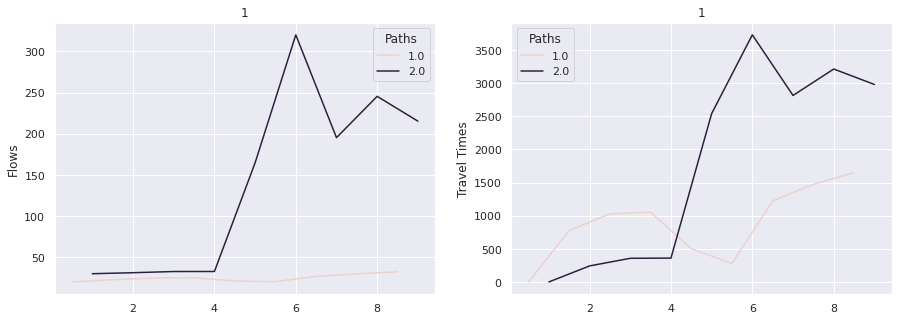

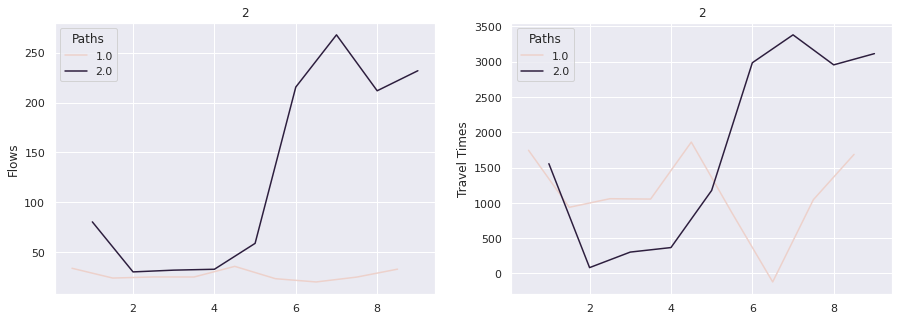

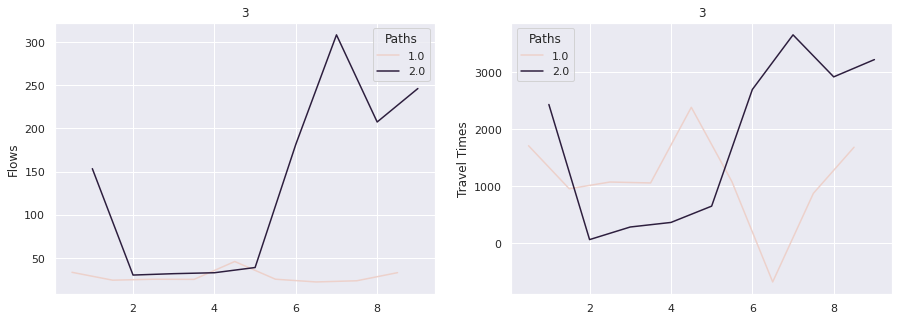

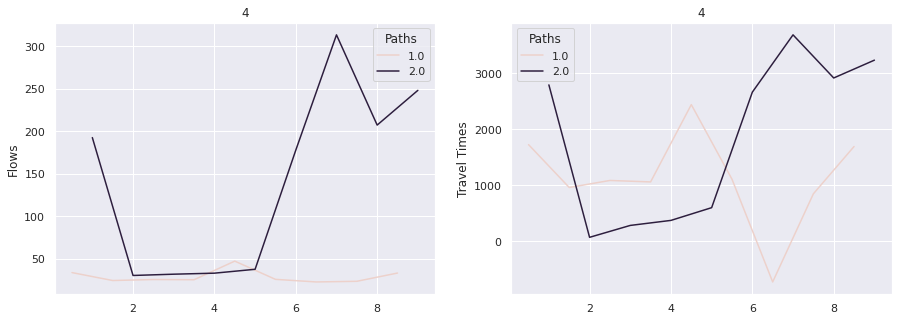

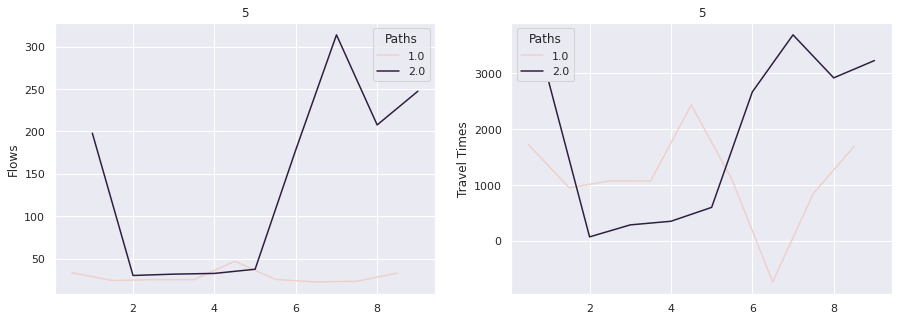

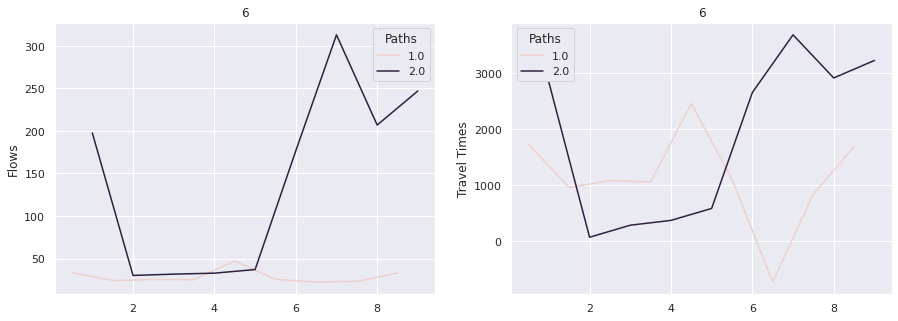

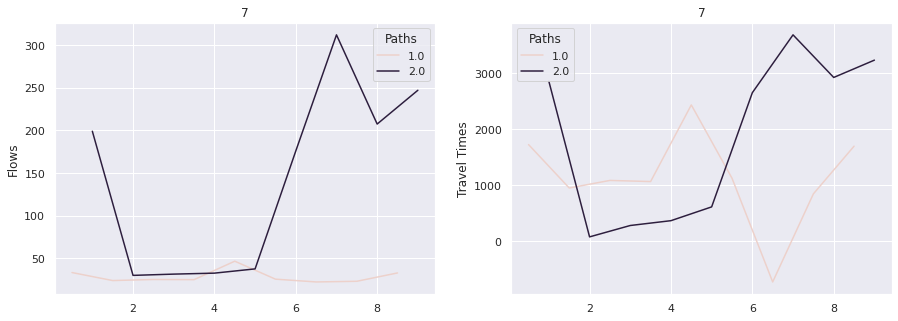

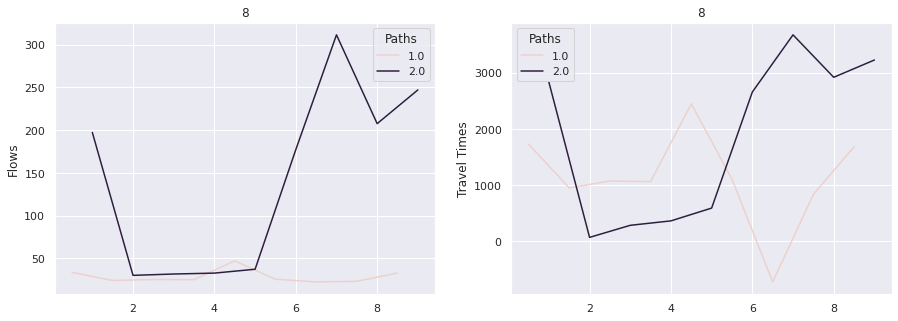

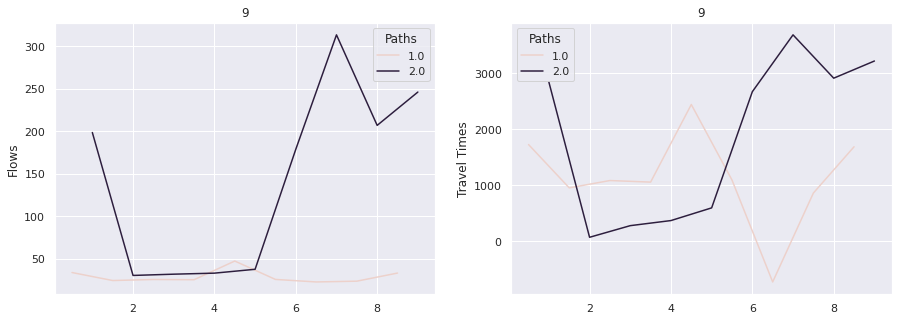

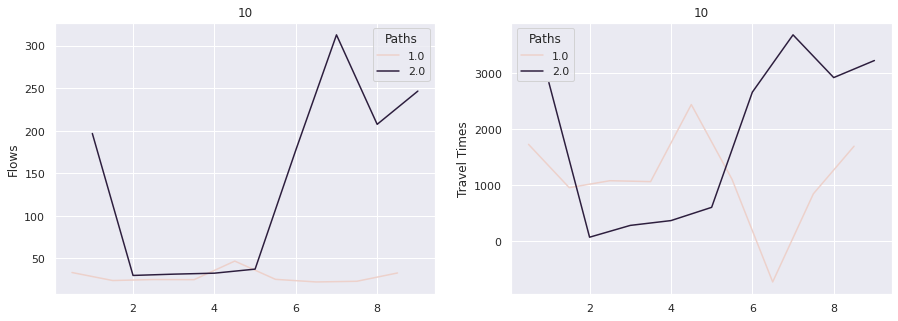

In [ ]:
# Plotting per day evolution of flows and travel times
print('In the graphs below we can observe the evolution of flows and travel times for of the 10 days for the paths 1 and 2')
sns.set(rc={'figure.figsize':(15,5)})
a=np.arange(1,19)
for i in range(1,1+days):
  part= complete_07[(complete_07.Day == i)]
  fig, axs = plt.subplots(ncols=2)
  sns.lineplot(data=part, x=a/2, y="Flows", hue="Paths",ax=axs[0]).set(title=i)   
  sns.lineplot(data=part, x=a/2, y="Travel Times", hue="Paths",ax=axs[1]).set(title=i)  

Since we notice little to no difference between the days in terms of flows and travel times. We decide to plot the evolution over the 10 days together.

[Text(0.5, 1.0, '10')]

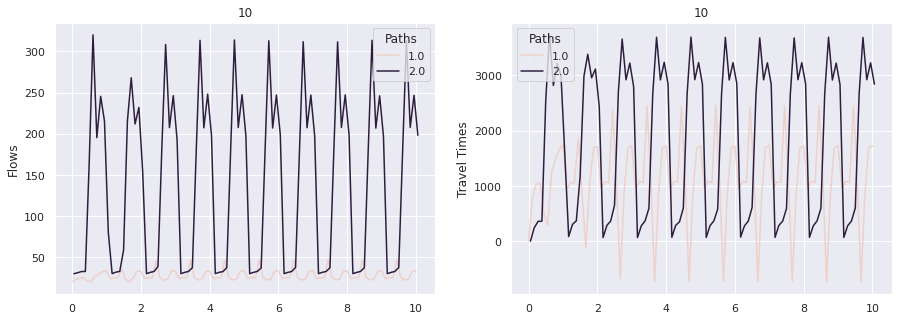

In [ ]:
# In this graph we can observe the evolution of of flows and travel times for paths 1 and 2 for all the 10 periods we set
fig, axs = plt.subplots(ncols=2)
sns.set(rc={'figure.figsize':(15,5)})
sns.lineplot(data=complete_07, x=complete_07.index/18, y="Flows", hue="Paths",ax=axs[0]).set(title=i)   
sns.lineplot(data=complete_07, x=complete_07.index/18, y="Travel Times", hue="Paths",ax=axs[1]).set(title=i) 

We remarque that starting from day 3 the same trend is repeated in each day in terms of flows and travel times between  paths 1 and 2

[Text(0.5, 1.0, 'Total Flow')]

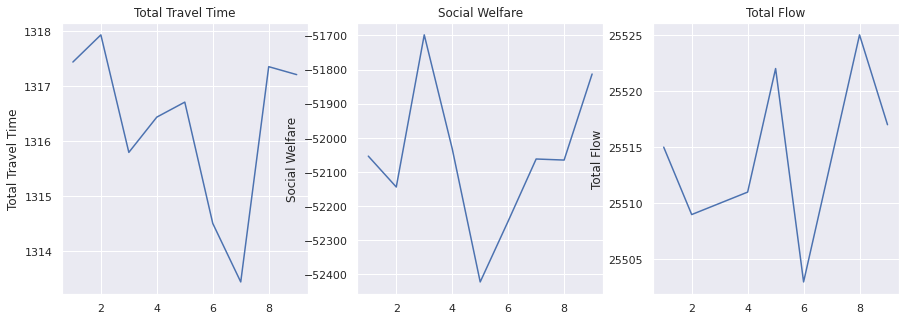

In [ ]:
# Plotting for learning rate 0.7
# Removing day 1 - no learning rate
important_variables_07=important_variables_07[1:]
dynamics_07=dynamics_07[1:]

fig, axs = plt.subplots(ncols=3)
sns.set(rc={'figure.figsize':(13,13)})
sns.lineplot(data=important_variables_07,x=important_variables_07.index, y="Total Travel Time", ax=axs[0]).set(title="Total Travel Time")
sns.lineplot(data=important_variables_07,x=important_variables_07.index, y="Social Welfare", ax=axs[1]).set(title="Social Welfare")
sns.lineplot(data=important_variables_07,x=important_variables_07.index, y="Total Flow", ax=axs[2]).set(title="Total Flow")

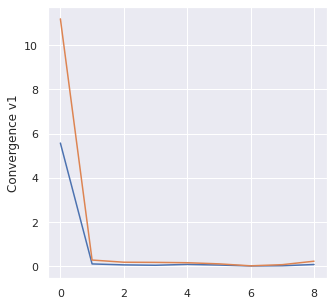

In [ ]:
# Plotting convergence
sns.set(rc={'figure.figsize':(5,5)})
fig, ax = plt.subplots()
ax= sns.lineplot(data=convergence_07,x=convergence_07.index, y="Convergence v1")
ax1 = sns.lineplot(data=convergence_07,x=convergence_07.index, y="Convergence v2")

## Plotting for learning rate of 30%

In [ ]:
# Turn the total list of all hours of all days into a dataframe
data  = list(itertools.chain(*total))
complete_03 = pd.DataFrame.from_records(data)
complete_03.columns = ['Paths', 'Travel Times', 'Flows']
val = 1
complete_03['Day'] = [val + floor(i / 18) for i in range(len(complete_03.index))]
complete_03

,Paths,Travel Times,Flows,Day
0,1.0,0.0,20.000000,1.0
1,2.0,0.0,30.000000,1.0
2,1.0,776.0,22.730957,1.0
3,2.0,242.0,31.220083,1.0
4,1.0,1029.0,24.802000,1.0
...,...,...,...,...
177,2.0,2920.0,207.633333,10.0
178,1.0,1693.0,32.998862,10.0
179,2.0,3225.0,246.679688,10.0
180,1.0,1721.0,33.432385,11.0


In the graphs below we can observe the evolution of flows and travel times per day for the different paths


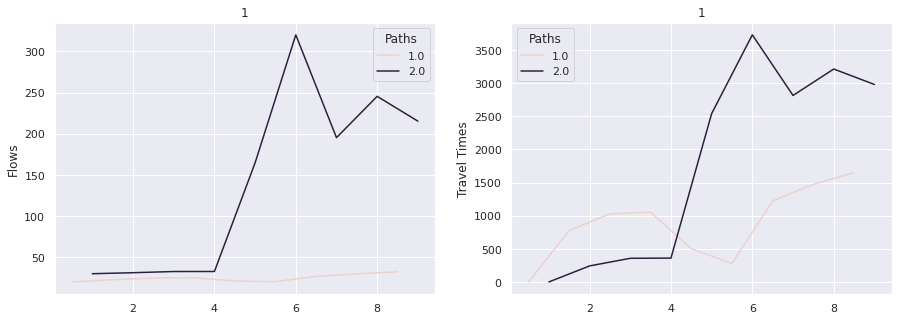

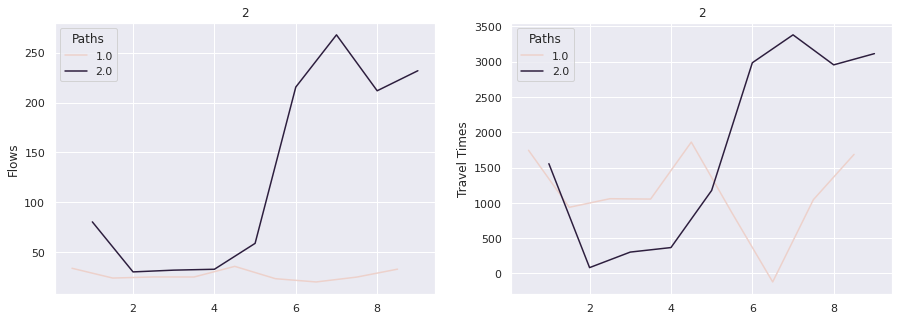

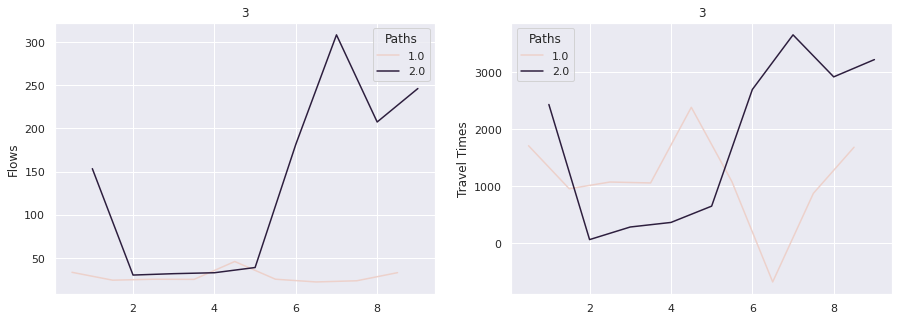

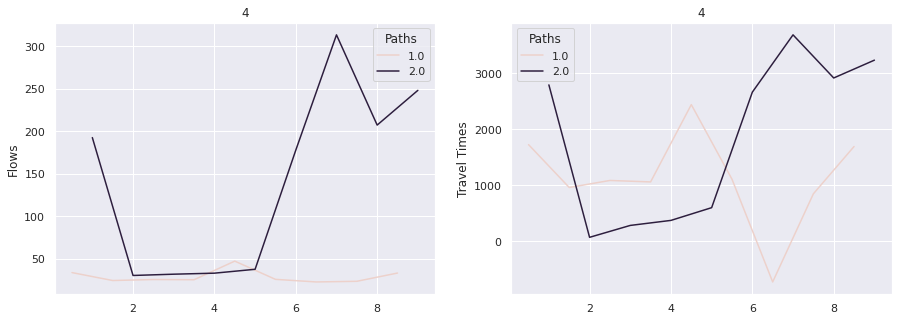

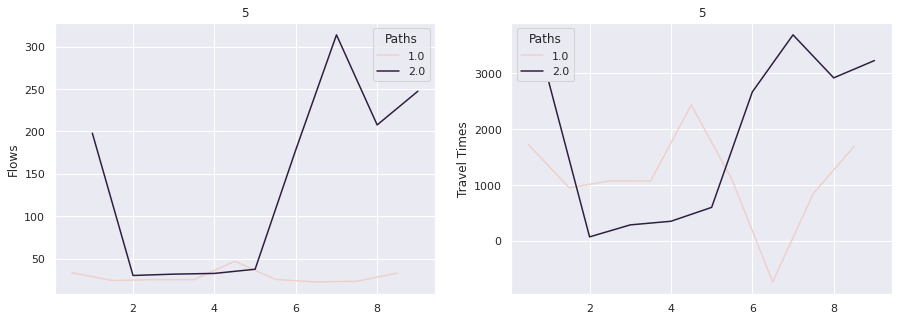

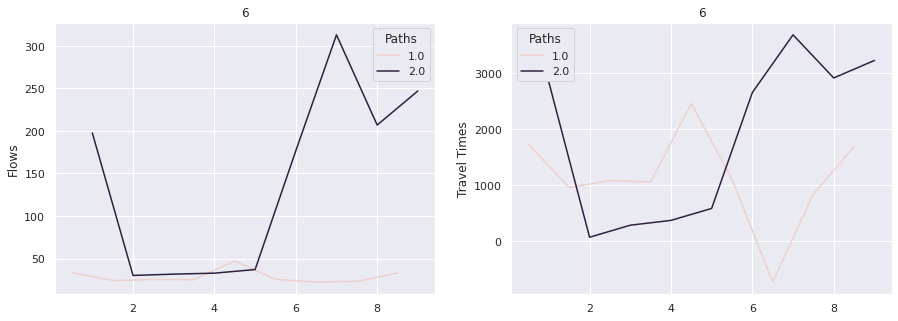

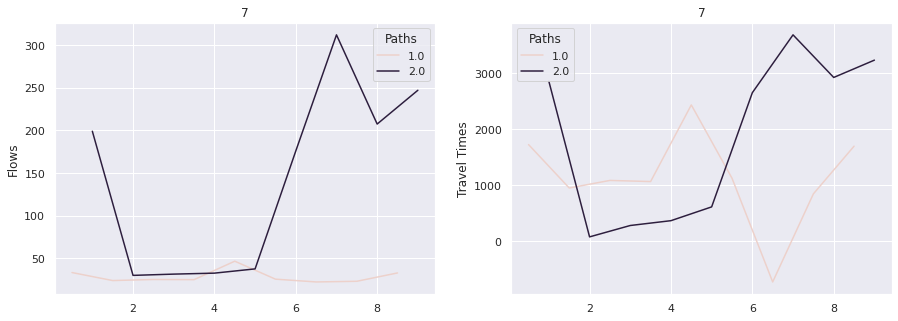

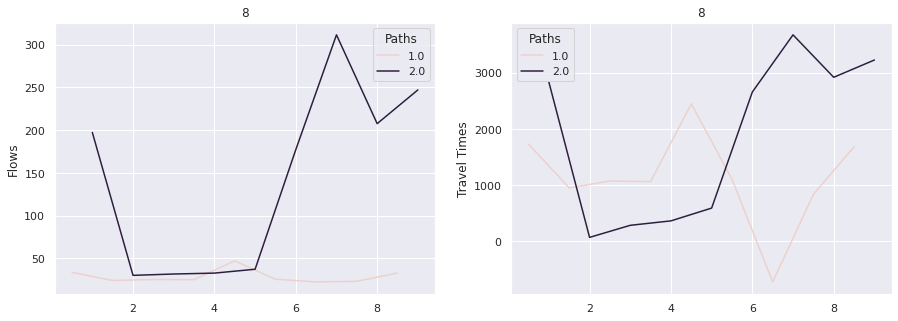

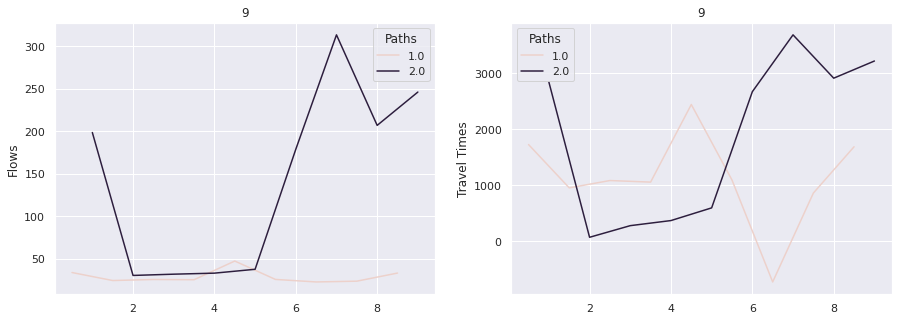

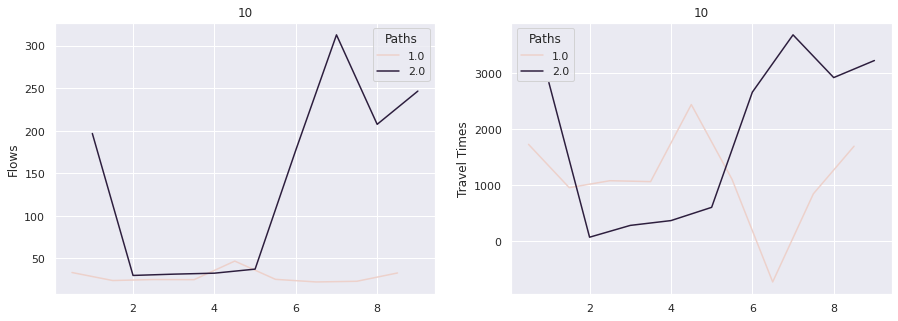

In [ ]:
# Plotting per day evolution of flows and travel times
print('In the graphs below we can observe the evolution of flows and travel times per day for the different paths')
sns.set(rc={'figure.figsize':(15,5)})
a=np.arange(1,19)
for i in range(1,1+days):
  part= complete_03[(complete_03.Day == i)]
  fig, axs = plt.subplots(ncols=2)
  sns.lineplot(data=part, x=a/2, y="Flows", hue="Paths",ax=axs[0]).set(title=i)   
  sns.lineplot(data=part, x=a/2, y="Travel Times", hue="Paths",ax=axs[1]).set(title=i) 

Since we notice little to no difference between the days in terms of flows and travel times. We decide to plot the evolution over the 10 days together.

[Text(0.5, 1.0, '10')]

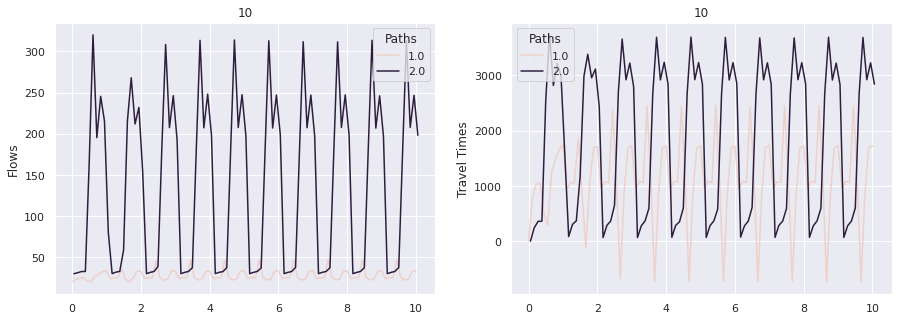

In [ ]:
# In this graph we can observe the evolution of of flows and travel times for all the period we set
fig, axs = plt.subplots(ncols=2)
sns.set(rc={'figure.figsize':(15,5)})
sns.lineplot(data=complete_03, x=complete_03.index/18, y="Flows", hue="Paths",ax=axs[0]).set(title=i)   
sns.lineplot(data=complete_03, x=complete_03.index/18, y="Travel Times", hue="Paths",ax=axs[1]).set(title=i) 

[Text(0.5, 1.0, 'Total Flow')]

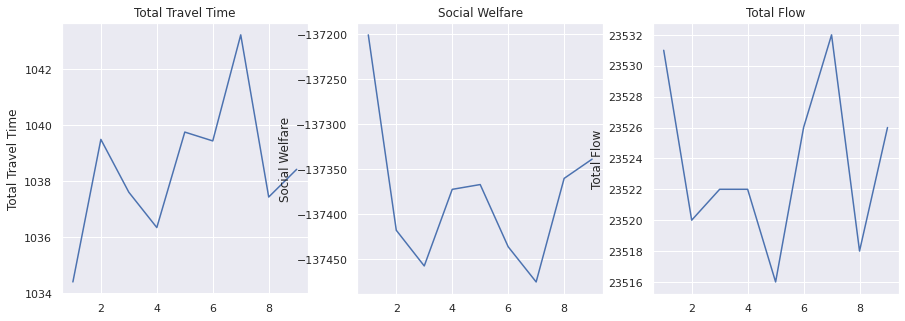

In [ ]:
# Plotting for learning rate 0.3
# Removing day 1 - no learning rate
important_variables_03=important_variables_03[1:]
dynamics_03=dynamics_03[1:]

fig, axs = plt.subplots(ncols=3)
sns.set(rc={'figure.figsize':(13,13)})
sns.lineplot(data=important_variables_03,x=important_variables_03.index, y="Total Travel Time", ax=axs[0]).set(title="Total Travel Time")
sns.lineplot(data=important_variables_03,x=important_variables_03.index, y="Social Welfare", ax=axs[1]).set(title="Social Welfare")
sns.lineplot(data=important_variables_03,x=important_variables_03.index, y="Total Flow", ax=axs[2]).set(title="Total Flow")

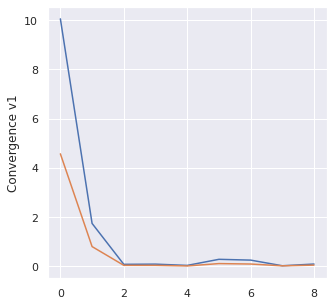

In [ ]:
# Plotting convergence
sns.set(rc={'figure.figsize':(5,5)})
fig, ax = plt.subplots()
ax= sns.lineplot(data=convergence_03,x=convergence_03.index, y="Convergence v1")
ax1 = sns.lineplot(data=convergence_03,x=convergence_03.index, y="Convergence v2")

## Plotting for learning rate of 90%

In [ ]:
# Turn the total list of all hours of all days into a dataframe
data  = list(itertools.chain(*total))
complete_09 = pd.DataFrame.from_records(data)
complete_09.columns = ['Paths', 'Travel Times', 'Flows']
val = 1
complete_09['Day'] = [val + floor(i / 18) for i in range(len(complete_09.index))]
complete_09

,Paths,Travel Times,Flows,Day
0,1.0,0.0,20.000000,1.0
1,2.0,0.0,30.000000,1.0
2,1.0,776.0,22.730957,1.0
3,2.0,242.0,31.220083,1.0
4,1.0,1029.0,24.802000,1.0
...,...,...,...,...
177,2.0,2920.0,207.633333,10.0
178,1.0,1693.0,32.998862,10.0
179,2.0,3225.0,246.679688,10.0
180,1.0,1721.0,33.432385,11.0


In the graphs below we can observe the evolution of flows and travel times per day for the different paths


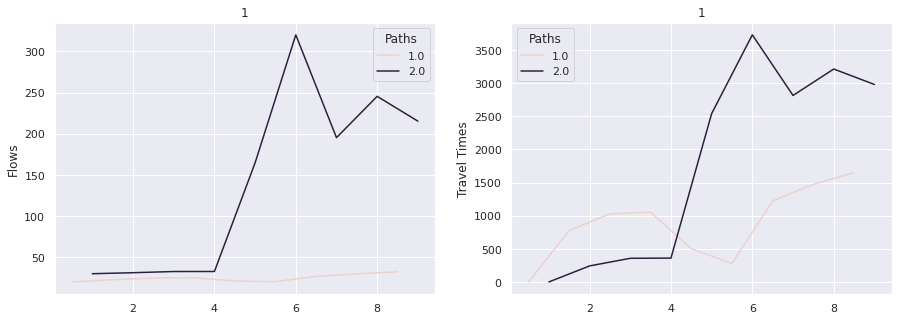

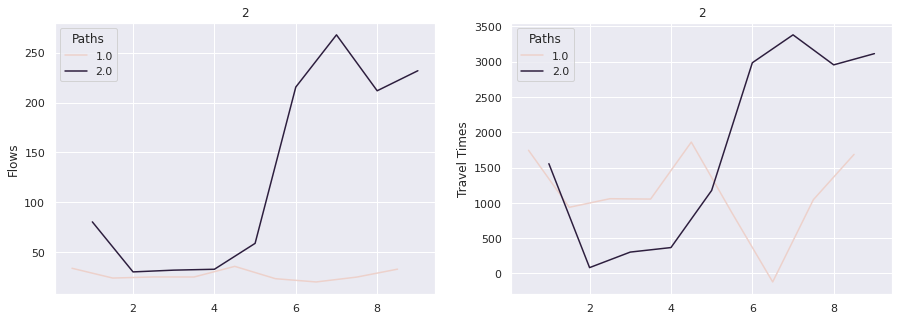

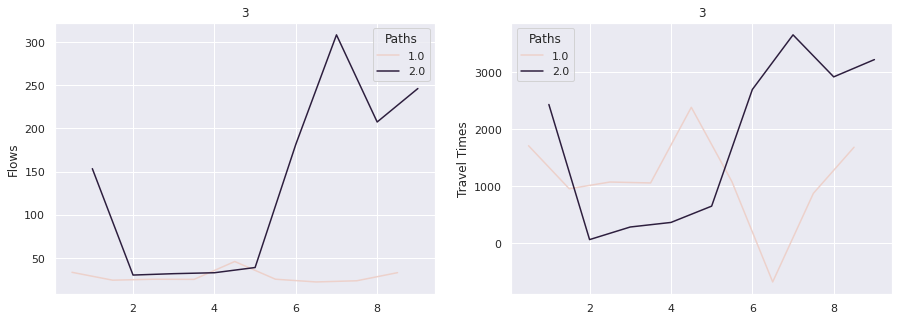

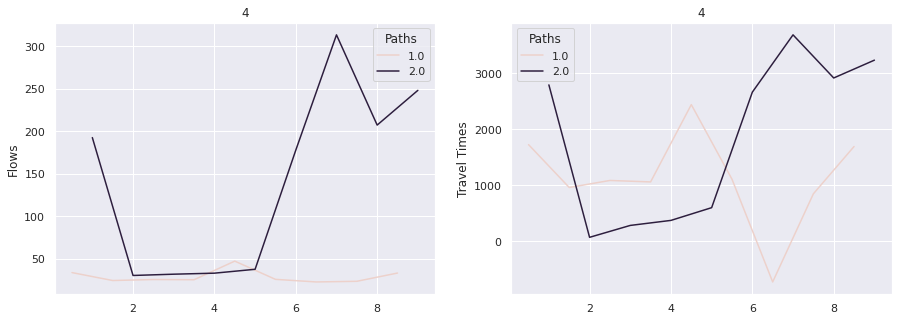

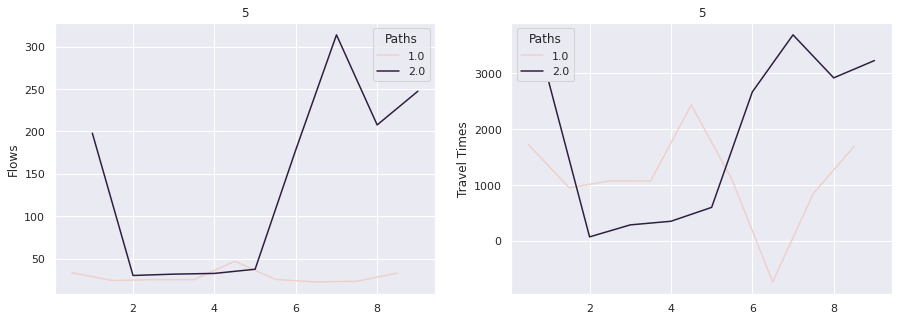

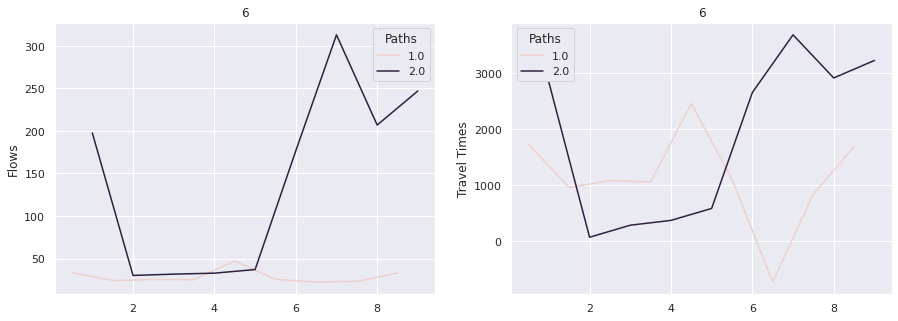

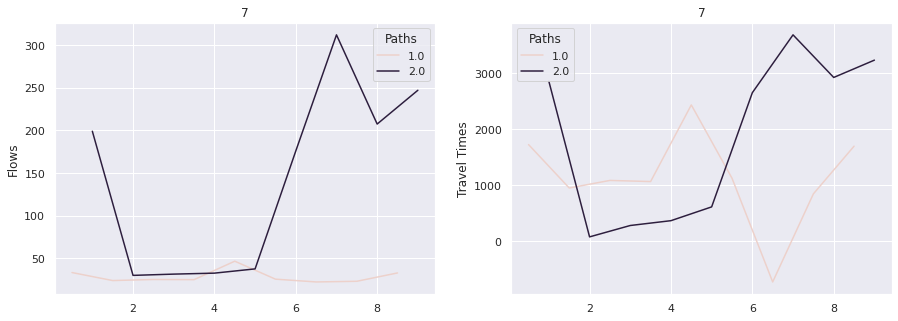

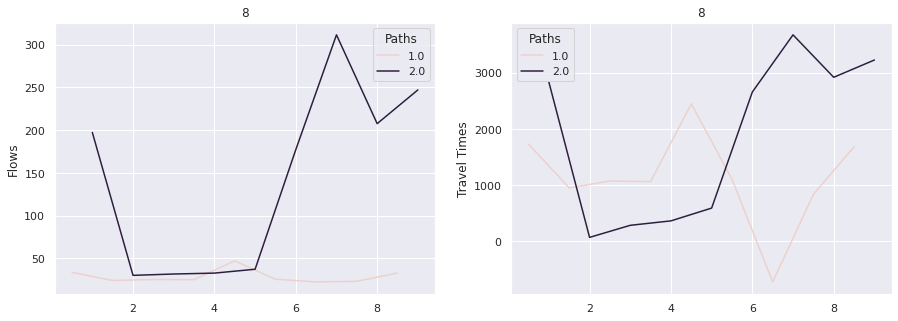

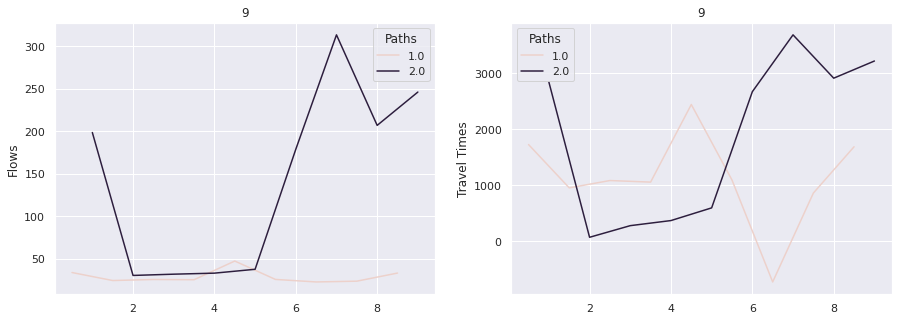

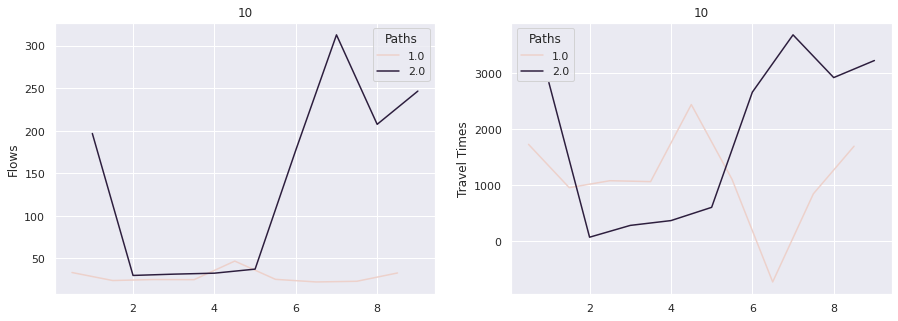

In [ ]:
# Plotting per day evolution of flows and travel times
print('In the graphs below we can observe the evolution of flows and travel times per day for the different paths')
sns.set(rc={'figure.figsize':(15,5)})
a=np.arange(1,19)
for i in range(1,1+days):
  part= complete_09[(complete_09.Day == i)]
  fig, axs = plt.subplots(ncols=2)
  sns.lineplot(data=part, x=a/2, y="Flows", hue="Paths",ax=axs[0]).set(title=i)    #'Flows per Hour')
  sns.lineplot(data=part, x=a/2, y="Travel Times", hue="Paths",ax=axs[1]).set(title=i)  #'Travel Times per Hour')

[Text(0.5, 1.0, '10')]

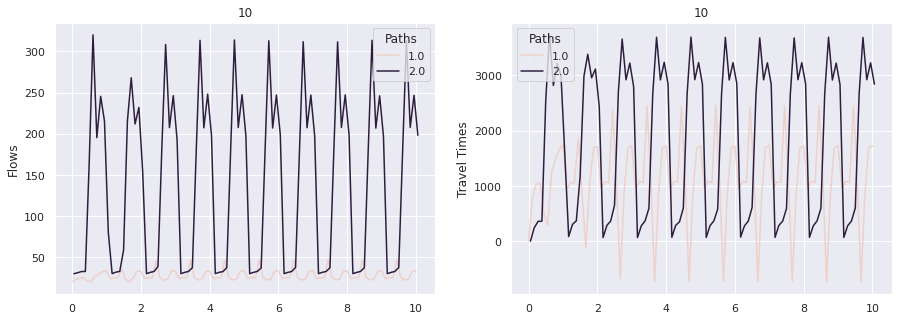

In [ ]:
# In this graph we can observe the evolution of of flows and travel times for all the period we set
fig, axs = plt.subplots(ncols=2)
sns.set(rc={'figure.figsize':(15,5)})
sns.lineplot(data=complete_09, x=complete_09.index/18, y="Flows", hue="Paths",ax=axs[0]).set(title=i)    #'Flows per Hour')
sns.lineplot(data=complete_09, x=complete_09.index/18, y="Travel Times", hue="Paths",ax=axs[1]).set(title=i) 

[Text(0.5, 1.0, 'Total Flow')]

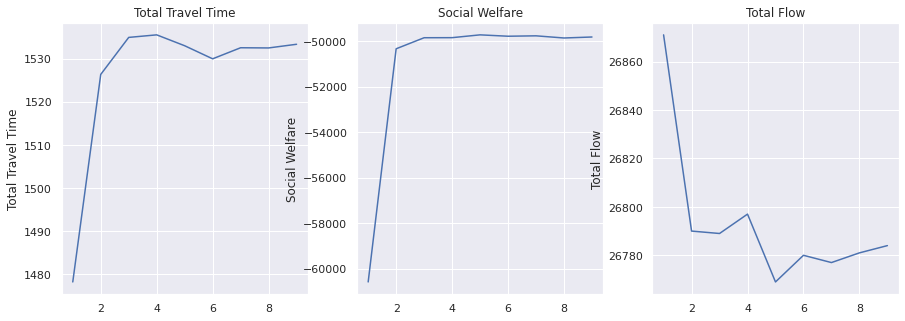

In [ ]:
# Plotting for learning rate 0.9
# Removing day 1 - no learning rate
important_variables_09=important_variables_09[1:]
dynamics_09=dynamics_09[1:]
fig, axs = plt.subplots(ncols=3)#,nrows=2)
sns.set(rc={'figure.figsize':(13,13)})
sns.lineplot(data=important_variables_09,x=important_variables_09.index, y="Total Travel Time", ax=axs[0]).set(title="Total Travel Time")
sns.lineplot(data=important_variables_09,x=important_variables_09.index, y="Social Welfare", ax=axs[1]).set(title="Social Welfare")
sns.lineplot(data=important_variables_09,x=important_variables_09.index, y="Total Flow", ax=axs[2]).set(title="Total Flow")

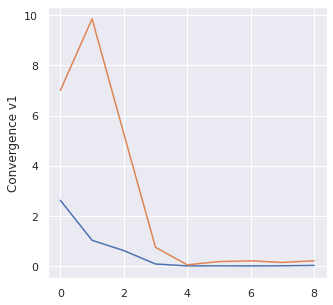

In [ ]:
# Plotting convergence
sns.set(rc={'figure.figsize':(5,5)})
fig, ax = plt.subplots()
ax= sns.lineplot(data=convergence_09,x=convergence_09.index, y="Convergence v1")
ax1 = sns.lineplot(data=convergence_09,x=convergence_09.index, y="Convergence v2")

**Analysis of Total Travel Time, Social Welfare, and Total Flow for varying learning rates**

The graphs for a learning rate of 0.3 and 0.7 still show a lot of variation over the days. On the other hand, when looking at the graphs for a learning rate of 0.9, it can be observed that a stable situation is reached. This is not really obvious for the total flow, in which still some variation is visible, but for total travel time and especially for social welfare, the graph become flat really fast. After two days, an equilibrium seems to be reached already.

\

**Convergence Analysis for varying learning rates**

Using a learning rate of 0.3 the convergence is observed after 2 iterations, while with a 0.9 learning rate after 4 iterations. The best convergence is observed after only 1 day with a learning rate of 0.7. We can conclude that a very low or very high learning rate is not the best for the behavior of drivers. The best case is with a high enough learning rate(In this case 0.7)


